The following is an implementation of the paper https://www.sciencedirect.com/science/article/pii/S2666386423005015#bib7 as discussed in [this post](https://www.kaggle.com/competitions/llm-detect-ai-generated-text/discussion/454702).  20 different features are extracted and a XGBoost model is trained.  Because we're using AUROC, rather than combining votes per paragraph, we average prediction probs per paragraph.

I've implemented the 20 features each as a separate function to make it more flexible to add/remove custom features in the future.

In [1]:
import re, statistics
import pandas as pd
from tqdm import tqdm
import xgboost as xgb
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/kaggle/input/llm-7-prompt-training-dataset/train_essays_RDizzl3_seven_v1.csv')
df.head()

,text,label
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [3]:
#For now just downsample human generated texts so we start with a balanced dataset.

df_label_0 = df[df['label'] == 0]
df_label_1 = df[df['label'] == 1]

df_label_0_downsampled = df_label_0.sample(len(df_label_1), random_state=42)
balanced_df = pd.concat([df_label_0_downsampled, df_label_1])

df_train = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
df_train['label'].value_counts()

label
1    1621
0    1621
Name: count, dtype: int64

In [5]:
#texts and labels will be the list that hold our relevant data

text = df_train.iloc[0]['text']
texts = df_train['text'].tolist()
labels = df_train['label'].tolist()
print(text)

While the Facial Action Coding System technology described in the article aims to provide insight into students' emotional states, its use to analyze facial expressions in the classroom raises some valid concerns. On one hand, this technology could help teachers understand how their lessons are being received on an individual level and allow them to adjust their teaching approaches if students seem disengaged or confused. Identifying strong negative emotions like frustration early on may help teachers address issues before they escalate. However, there are also risks to closely monitoring students' facial expressions without their consent. Continuously analyzing facial cues could infringe on students' privacy and feel oppressive or distracting over time. It may also lead teachers to make assumptions without understanding the full context of students' lives outside the classroom. Rather than gaining a nuanced perspective, this technology risks reducing complex human emotions and experie

In [6]:
def count_sentences_per_paragraph(text):
    paragraphs = text.split('\n\n')
    paragraphs = [p for p in paragraphs if p.strip()]
    
    # Count sentences in each paragraph
    sentence_counts = []
    for paragraph in paragraphs:
        sentences = re.split(r'[.?!]+', paragraph)
        sentences = [s for s in sentences if s.strip()]
        sentence_counts.append(len(sentences))
    
    return sentence_counts

sentence_counts = count_sentences_per_paragraph(text)
print(sentence_counts)

[10]


In [7]:
def count_words_per_paragraph(text):
    paragraphs = text.split('\n\n')
    paragraphs = [p for p in paragraphs if p.strip()]
    
    word_counts = []
    for paragraph in paragraphs:
        words = paragraph.split()
        word_counts.append(len(words))
    
    return word_counts

word_counts = count_words_per_paragraph(text)
print(word_counts)

[224]


In [8]:
def detect_parentheses_per_paragraph(text):
    paragraphs = text.split('\n\n')
    
    parentheses_presence = []
    for paragraph in paragraphs:
        if '(' in paragraph or ')' in paragraph:
            parentheses_presence.append(1)
        else:
            parentheses_presence.append(0)
    
    return parentheses_presence

parentheses_presence = detect_parentheses_per_paragraph(text)
print(parentheses_presence)

[0]


In [9]:
def detect_dash_per_paragraph(text):
    paragraphs = text.split('\n\n')
    
    dash_presence = []
    for paragraph in paragraphs:
        if '-' in paragraph:
            dash_presence.append(1)
        else:
            dash_presence.append(0)
    
    return dash_presence

dash_presence = detect_dash_per_paragraph(text)
print(dash_presence)

[1]


In [10]:
def detect_semicolon_colon_per_paragraph(text):
    paragraphs = text.split('\n\n')
    
    punctuation_presence = []
    for paragraph in paragraphs:
        if ';' in paragraph or ':' in paragraph:
            punctuation_presence.append(1)
        else:
            punctuation_presence.append(0)
    
    return punctuation_presence

semicolon_colon_presence = detect_semicolon_colon_per_paragraph(text)
print(semicolon_colon_presence)

[0]


In [11]:
def detect_question_mark_per_paragraph(text):
    paragraphs = text.split('\n\n')
    
    question_mark_presence = []
    for paragraph in paragraphs:
        if '?' in paragraph:
            question_mark_presence.append(1)
        else:
            question_mark_presence.append(0)
    
    return question_mark_presence

question_mark_presence = detect_question_mark_per_paragraph(text)
print(question_mark_presence)

[0]


In [12]:
def detect_apostrophe_per_paragraph(text):
    paragraphs = text.split('\n\n')
    
    apostrophe_presence = []
    for paragraph in paragraphs:
        if "'" in paragraph:
            apostrophe_presence.append(1)
        else:
            apostrophe_presence.append(0)
    
    return apostrophe_presence

apostrophe_presence = detect_apostrophe_per_paragraph(text)
print(apostrophe_presence)

[1]


In [13]:
def std_dev_sentence_length_per_paragraph(text):
    paragraphs = text.split('\n\n')
    
    std_devs = []
    for paragraph in paragraphs:
        sentences = re.split(r'[.?!]+', paragraph)
        sentence_lengths = [len(sentence.split()) for sentence in sentences if sentence.strip()]
        
        if len(sentence_lengths) > 1:
            std_dev = statistics.stdev(sentence_lengths)
        else:
            std_dev = 0  # if not enough sentences
        std_devs.append(std_dev)
    
    return std_devs

std_devs = std_dev_sentence_length_per_paragraph(text)
print(std_devs)

[7.290785661062569]


In [14]:
def mean_diff_in_sentence_length_per_paragraph(text):
    paragraphs = text.split('\n\n')
    
    mean_diffs = []
    for paragraph in paragraphs:
        sentences = re.split(r'[.?!]+', paragraph)
        sentence_lengths = [len(sentence.split()) for sentence in sentences if sentence.strip()]
        differences = [abs(sentence_lengths[i] - sentence_lengths[i+1]) for i in range(len(sentence_lengths) - 1)]
        
        if differences:
            mean_diff = statistics.mean(differences)
        else:
            mean_diff = 0  # handle where no consecutive sentences or only empty sentences are present
        mean_diffs.append(mean_diff)
    
    return mean_diffs

mean_diffs = mean_diff_in_sentence_length_per_paragraph(text)
print(mean_diffs)

[5.222222222222222]


In [15]:
def detect_short_sentences_per_paragraph(text):
    paragraphs = text.split('\n\n')
    
    short_sentence_presence = []
    for paragraph in paragraphs:
        sentences = re.split(r'[.?!]+', paragraph)
        has_short_sentence = any(len(sentence.split()) < 11 for sentence in sentences if sentence.strip())  #hard coded to 11 words
        short_sentence_presence.append(1 if has_short_sentence else 0)
    
    return short_sentence_presence

short_sentence_presence = detect_short_sentences_per_paragraph(text)
print(short_sentence_presence)

[0]


In [16]:
def detect_long_sentences_per_paragraph(text):
    paragraphs = text.split('\n\n')
    
    long_sentence_presence = []
    for paragraph in paragraphs:
        sentences = re.split(r'[.?!]+', paragraph)
        has_long_sentence = any(len(sentence.split()) > 34 for sentence in sentences if sentence.strip())  #hard coded to 34 words
        long_sentence_presence.append(1 if has_long_sentence else 0)
    
    return long_sentence_presence

long_sentence_presence = detect_long_sentences_per_paragraph(text)
print(long_sentence_presence)

[0]


In [17]:
def detect_numbers_per_paragraph(text):
    paragraphs = text.split('\n\n')
    
    number_presence = []
    for paragraph in paragraphs:
        has_number = any(char.isdigit() for char in paragraph)
        number_presence.append(1 if has_number else 0)
    
    return number_presence

number_presence = detect_numbers_per_paragraph(text)
print(number_presence)

[0]


In [18]:
def detect_capital_letters_vs_periods(text):
    paragraphs = text.split('\n\n')
    
    capital_vs_period_presence = []
    for paragraph in paragraphs:
        capital_letters = sum(1 for char in paragraph if char.isupper())
        periods = paragraph.count('.')

        if capital_letters >= 2 * periods:
            capital_vs_period_presence.append(1)
        else:
            capital_vs_period_presence.append(0)
    
    return capital_vs_period_presence

capital_vs_period_presence = detect_capital_letters_vs_periods(text)
print(capital_vs_period_presence)

[0]


In [19]:
def detect_word_alhough(text):
    paragraphs = text.split('\n\n')
    presence = [1 if 'although' in paragraph.lower() else 0 for paragraph in paragraphs]
    return presence

def detect_word_however(text):
    paragraphs = text.split('\n\n')
    presence = [1 if 'however' in paragraph.lower() else 0 for paragraph in paragraphs]
    return presence

def detect_word_but(text):
    paragraphs = text.split('\n\n')
    presence = [1 if ' but ' in paragraph.lower() else 0 for paragraph in paragraphs]
    return presence

def detect_word_because(text):
    paragraphs = text.split('\n\n')
    presence = [1 if 'because' in paragraph.lower() else 0 for paragraph in paragraphs]
    return presence

def detect_word_this(text):
    paragraphs = text.split('\n\n')
    presence = [1 if 'this' in paragraph.lower() else 0 for paragraph in paragraphs]
    return presence

def detect_word_others_researchers(text):
    paragraphs = text.split('\n\n')
    presence = [1 if 'others' in paragraph.lower() or 'researchers' in paragraph.lower() else 0 for paragraph in paragraphs]
    return presence

def detect_word_et(text):
    paragraphs = text.split('\n\n')
    presence = [1 if ' et ' in paragraph.lower() else 0 for paragraph in paragraphs]
    return presence

In [20]:
#Loop through all text in texts
results = []
for text in tqdm(texts):
    result = {
        'sentences_per_paragraph': count_sentences_per_paragraph(text),
        'words_per_paragraph': count_words_per_paragraph(text),
        'parentheses_presence': detect_parentheses_per_paragraph(text),
        'dash_presence': detect_dash_per_paragraph(text),
        'semicolon_colon_presence': detect_semicolon_colon_per_paragraph(text),
        'question_mark_presence': detect_question_mark_per_paragraph(text),
        'apostrophe_presence': detect_apostrophe_per_paragraph(text),
        'std_dev_sentence_length': std_dev_sentence_length_per_paragraph(text),
        'mean_diff_consecutive_sentences': mean_diff_in_sentence_length_per_paragraph(text),
        'short_sentence_presence': detect_short_sentences_per_paragraph(text),
        'long_sentence_presence': detect_long_sentences_per_paragraph(text),
        'numbers_sentence_presence': detect_numbers_per_paragraph(text),
        'capital_vs_period_presence': detect_capital_letters_vs_periods(text),
        'word_alhough_presence': detect_word_alhough(text),
        'word_however_presence': detect_word_however(text),
        'word_but_presence': detect_word_but(text),
        'word_because_presence': detect_word_because(text),
        'word_this_presence': detect_word_this(text),
        'word_others_researchers_presence': detect_word_others_researchers(text),
        'word_et_presence': detect_word_et(text),
    }
    results.append(result)

100%|██████████| 3242/3242 [00:04<00:00, 783.45it/s]


In [21]:
rows = []

# iterate over both results and their corresponding labels
for text_id, (result, label) in enumerate(zip(results, labels)):
    # flatten the results for each paragraph into individual rows
    for i in range(len(result['sentences_per_paragraph'])):
        row = {key: value[i] if isinstance(value, list) and len(value) > i else value for key, value in result.items()}
        row['text_id'] = text_id
        row['label'] = label
        rows.append(row)

#dataframe with all of our data (by paragraph)
df_features = pd.DataFrame(rows)

In [22]:
df_features.head()

,sentences_per_paragraph,words_per_paragraph,parentheses_presence,dash_presence,semicolon_colon_presence,question_mark_presence,apostrophe_presence,std_dev_sentence_length,mean_diff_consecutive_sentences,short_sentence_presence,...,capital_vs_period_presence,word_alhough_presence,word_however_presence,word_but_presence,word_because_presence,word_this_presence,word_others_researchers_presence,word_et_presence,text_id,label
0,10,224,0,1,0,0,1,7.290786,5.222222,0,...,0,0,1,0,0,1,0,0,0,1
1,4,57,0,0,0,0,0,2.986079,4.000000,1,...,0,0,1,1,0,0,0,0,1,0
2,1,11,0,0,0,0,0,0.000000,0.000000,0,...,1,0,0,0,0,0,0,0,1,0
3,5,67,0,0,0,0,0,6.465292,7.500000,1,...,1,0,1,0,0,0,1,0,1,0
4,4,54,0,0,0,0,0,6.608076,8.000000,1,...,1,0,0,1,0,0,0,0,1,0


In [23]:
#train a xgboost model

params = {
    'max_depth': 4,
    'n_estimators': 50,
    'learning_rate': 0.2,
    'objective': 'multi:softmax',
    'num_class': 2,
    'eval_metric': 'auc',
    'booster': 'gbtree',
    'subsample': 1,
    'colsample_bytree': 1
}

X = df_features.drop(['label', 'text_id'], axis=1)
y = df_features['label']

class_ratio = y.value_counts(normalize=True)
scale_pos_weight = class_ratio[0] / class_ratio[1]

# 90/10 train/test split for now
unique_text_ids = df_features['text_id'].unique()
train_ids, test_ids = train_test_split(unique_text_ids, test_size=0.1, random_state=42)
train_data = df_features[df_features['text_id'].isin(train_ids)]
test_data = df_features[df_features['text_id'].isin(test_ids)]

X_train = train_data.drop(['label', 'text_id'], axis=1)
y_train = train_data['label']
X_test = test_data.drop(['label', 'text_id'], axis=1)
y_test = test_data['label']

# Initialize and train the XGBoost model
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred[:,1])
print("ROC_AUC_raw:", auc)

ROC_AUC_raw: 0.883849334103514


In [24]:
test_data['pred'] = y_pred[:,1]
average_predictions = test_data.groupby(['text_id', 'label'])['pred'].mean().reset_index()
average_predictions.head()

/tmp/ipykernel_20/539195195.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pred'] = y_pred[:,1]


,text_id,label,pred
0,0,1,0.556941
1,14,0,0.352546
2,17,0,0.261283
3,26,1,0.816989
4,30,0,0.163173


In [25]:
auc = roc_auc_score(average_predictions['label'], average_predictions['pred'])
print("ROC_AUC_aggregate:", auc)

ROC_AUC_aggregate: 0.9639069837903348


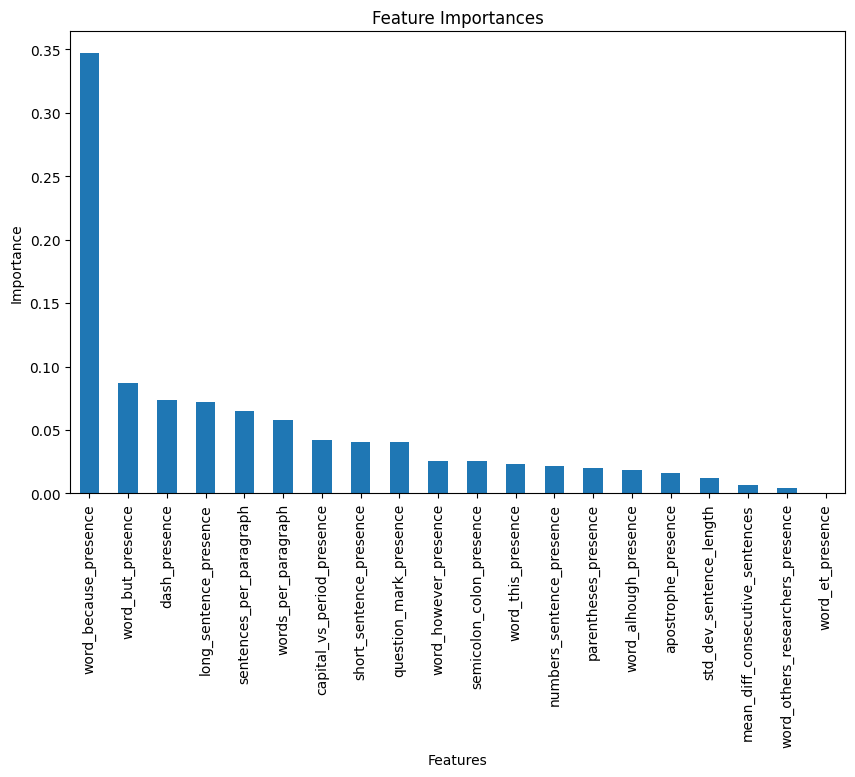

In [26]:
#look at some initial feature importance
feature_importances = model.feature_importances_
feature_names = X_train.columns
importance_series = pd.Series(feature_importances, index=feature_names)
importance_series = importance_series.sort_values(ascending=False)

# plot feature importantances
plt.figure(figsize=(10,6))
importance_series.plot(kind='bar')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()


In [27]:
#prepare test data for inference

df_test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')

text_test = df_test['text'].tolist()
text_ids = df_test['id'].tolist()

test_results = []
for text in tqdm(text_test):
    result = {
        'sentences_per_paragraph': count_sentences_per_paragraph(text),
        'words_per_paragraph': count_words_per_paragraph(text),
        'parentheses_presence': detect_parentheses_per_paragraph(text),
        'dash_presence': detect_dash_per_paragraph(text),
        'semicolon_colon_presence': detect_semicolon_colon_per_paragraph(text),
        'question_mark_presence': detect_question_mark_per_paragraph(text),
        'apostrophe_presence': detect_apostrophe_per_paragraph(text),
        'std_dev_sentence_length': std_dev_sentence_length_per_paragraph(text),
        'mean_diff_consecutive_sentences': mean_diff_in_sentence_length_per_paragraph(text),
        'short_sentence_presence': detect_short_sentences_per_paragraph(text),
        'long_sentence_presence': detect_long_sentences_per_paragraph(text),
        'numbers_sentence_presence': detect_numbers_per_paragraph(text),
        'capital_vs_period_presence': detect_capital_letters_vs_periods(text),
        'word_alhough_presence': detect_word_alhough(text),
        'word_however_presence': detect_word_however(text),
        'word_but_presence': detect_word_but(text),
        'word_because_presence': detect_word_because(text),
        'word_this_presence': detect_word_this(text),
        'word_others_researchers_presence': detect_word_others_researchers(text),
        'word_et_presence': detect_word_et(text),
    }
    test_results.append(result)


rows = []

# iterate over both results and their corresponding labels
for result, idx in zip(test_results, text_ids):
    # flatten the results for each paragraph into individual rows
    for i in range(len(result['sentences_per_paragraph'])):
        row = {key: value[i] if isinstance(value, list) and len(value) > i else value for key, value in result.items()}
        row['id'] = idx
        rows.append(row)

#dataframe with all of our data (by paragraph)
df_test_features = pd.DataFrame(rows)

100%|██████████| 3/3 [00:00<00:00, 9191.32it/s]


In [28]:
df_test_features.head()

,sentences_per_paragraph,words_per_paragraph,parentheses_presence,dash_presence,semicolon_colon_presence,question_mark_presence,apostrophe_presence,std_dev_sentence_length,mean_diff_consecutive_sentences,short_sentence_presence,...,numbers_sentence_presence,capital_vs_period_presence,word_alhough_presence,word_however_presence,word_but_presence,word_because_presence,word_this_presence,word_others_researchers_presence,word_et_presence,id
0,1,3,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0000aaaa
1,1,3,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1111bbbb
2,1,3,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,2222cccc


In [29]:
X_test = df_test_features.drop(['id'], axis=1)
y_pred = model.predict_proba(X_test)

In [30]:
df_test_features['generated'] = y_pred[:,1]
average_predictions = df_test_features.groupby(['id'])['generated'].mean().reset_index()

In [31]:
average_predictions.head()

,id,generated
0,0000aaaa,0.643403
1,1111bbbb,0.643403
2,2222cccc,0.868329


In [32]:
average_predictions.to_csv('submission.csv', index=False)